Úkol 5

In [ ]:
from itertools import product
from pysat.formula import CNF
from pysat.solvers import Solver

# Velikost desky 3x3
N = 3

# Prázdné pole reprezentujeme číslem 0
start_state = [
    [7, 2, 4],
    [5, 0, 6],
    [8, 3, 1]
]

goal_state = [
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8]
]

# Počet tahů, které chceme ověřit
k = 4 

# --- Pomocná funkce pro číslování proměnných ---
def var(tile, r, c, step):
    """Unikátní číslo proměnné pro SAT (od 1)."""
    return 1 + (((tile * N + r) * N + c) * (k + 1) + step)

# --- Funkce, která vrací sousedy pozice (nahoru, dolů, vlevo, vpravo) ---
def neighbors(r, c):
    for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
        nr, nc = r + dr, c + dc
        if 0 <= nr < N and 0 <= nc < N:
            yield nr, nc

# CNF formule (konjunkce klauzulí)
cnf = CNF()

tiles = list(range(0, 9))  # 0 je prázdné pole, 1–8 jsou dílky

# --- 1. Každý dílek je v každém kroku právě na jedné pozici ---
for t in tiles:
    for s in range(k + 1):
        # alespoň na jedné pozici
        cnf.append([var(t, r, c, s) for r, c in product(range(N), range(N))])
        # ne na dvou různých zároveň
        for (r1, c1), (r2, c2) in product(product(range(N), range(N)), repeat=2):
            if (r1, c1) < (r2, c2):
                cnf.append([-var(t, r1, c1, s), -var(t, r2, c2, s)])

# --- 2. Každá buňka obsahuje nejvýše jeden dílek ---
for r, c in product(range(N), range(N)):
    for s in range(k + 1):
        for t1, t2 in product(tiles, tiles):
            if t1 < t2:
                cnf.append([-var(t1, r, c, s), -var(t2, r, c, s)])

# --- 3. Počáteční a cílový stav ---
for r, c in product(range(N), range(N)):
    t = start_state[r][c]
    cnf.append([var(t, r, c, 0)])
    for t2 in tiles:
        if t2 != t:
            cnf.append([-var(t2, r, c, 0)])

for r, c in product(range(N), range(N)):
    t = goal_state[r][c]
    cnf.append([var(t, r, c, k)])
    for t2 in tiles:
        if t2 != t:
            cnf.append([-var(t2, r, c, k)])

# --- 4. Pravidla přechodu mezi kroky (jediný tah za časový krok) ---
for s in range(k):
    # Pozice prázdného pole (0)
    for r, c in product(range(N), range(N)):
        empty_here = var(0, r, c, s)
        moves = []
        for nr, nc in neighbors(r, c):
            # Můžeme vyměnit prázdné pole se sousedním dílkem
            for t in tiles[1:]:
                moves.append([
                    -empty_here,
                    -var(t, nr, nc, s),
                    var(0, nr, nc, s+1),
                    var(t, r, c, s+1)
                ])
        for clause in moves:
            cnf.append(clause)

# --- 5. Spuštění SAT řešitele ---
with Solver(name="g4") as solver:
    solver.append_formula(cnf)
    sat = solver.solve()
    print("SAT =", sat)


SAT = False


Úkol 3

In [14]:
# Tento program převádí úlohu výběru učitelů na problém splnitelnosti výrokových formulí (SAT)
# Každý učitel umí určitou množinu předmětů
# Cílem je zjistit, zda lze vybrat přesně k učitelů tak, aby pokryli všechny předměty

from itertools import combinations
from pysat.formula import CNF
from pysat.card import CardEnc
from pysat.solvers import Glucose3

def teacher_cover_sat(teachers_subjects, subjects, k):
    """
    teachers_subjects: dict[str, set[str]] - učitel -> množina předmětů, které umí vyučovat
    subjects: set[str] - všechny předměty, které je třeba pokrýt
    k: int - počet učitelů, které chceme vybrat
    """

    teachers = list(teachers_subjects.keys())
    m = len(teachers)

    # Proměnné x_i znamenají: učitel T_i je vybrán (True) nebo nevybrán (False)
    # Použijeme číslování proměnných 1..m (formát DIMACS)
    cnf = CNF()

    # 1) Omezení: musí být vybráno přesně k učitelů
    # To znamená, že právě k proměnných x_i je True
    card = CardEnc.equals(lits=list(range(1, m + 1)), bound=k, encoding=1)
    cnf.extend(card.clauses)

    # 2) Každý předmět musí být pokryt alespoň jedním vybraným učitelem
    # Pro každý předmět vytvoříme klauzuli (x_i ∨ x_j ∨ ...), kde učitelé umí daný předmět
    for subj in subjects:
        clause = []
        for i, t in enumerate(teachers, start=1):
            if subj in teachers_subjects[t]:
                clause.append(i)
        if clause:
            cnf.append(clause)
        else:
            # Pokud žádný učitel neumí daný předmět, úloha nemá řešení
            print(f"⚠️ Předmět {subj} neumí vyučovat žádný učitel — nelze pokrýt všechny předměty.")
            return None

    # 3) Použijeme SAT solver (Glucose3)
    solver = Glucose3()
    solver.append_formula(cnf.clauses)
    sat = solver.solve()

    if not sat:
        print("❌ Žádné řešení neexistuje — nelze vybrat k učitelů, kteří by pokryli všechny předměty.")
        return None

    # Pokud je splnitelné, zjistíme, které proměnné jsou True
    model = solver.get_model()
    chosen = [teachers[i - 1] for i in range(1, m + 1) if model[i - 1] > 0]

    print(f"✅ Nalezeno řešení! Vybráno {len(chosen)} učitelů z {m}: {chosen}")
    return chosen


# === Příklad použití ===
if __name__ == "__main__":
    # Definujeme učitele a jejich schopnosti
    teachers_subjects = {
        "T1": {"Matematika", "Fyzika"},
        "T2": {"Chemie"},
        "T3": {"Biologie", "Chemie"},
        "T4": {"Matematika", "Biologie"},
    }

    # Množina všech předmětů, které je třeba pokrýt
    subjects = {"Matematika", "Fyzika", "Chemie", "Biologie"}

    # Počet učitelů, které chceme vybrat
    k = 2

    teacher_cover_sat(teachers_subjects, subjects, k)


✅ Nalezeno řešení! Vybráno 2 učitelů z 4: ['T1', 'T3']


Úkol 4

In [17]:
# Tento kód generuje CNF pro hledání Hamiltonovské kružnice,
# zapisuje ho do DIMACS formátu
# a (volitelně) řeší CNF pomocí knihovny pysat (Glucose3) a rekonstruuje kružnici z modelu.
#
# Vyžaduje: pip install python-sat
from itertools import combinations

def varnum(v_idx, pos, n):
    """Převod na číslo proměnné: vrací kladné celé číslo pro x_{v_idx,pos}.
       v_idx: index vrcholu 0..n-1, pos: pozice 0..n-1."""
    return v_idx * n + pos + 1

def encode_hamiltonian_cnf(adj_list, fix_start_vertex=None):
    """
    adj_list: dict: vrchol -> množina sousedů
    fix_start_vertex: volitelný parametr - určuje, který vrchol bude pevně na pozici 0 (redukuje symetrii)
    Vrací (num_vars, clauses, vertices, varmap)
      - num_vars: počet proměnných
      - clauses: seznam klauzulí (každá klauzule je seznam intů)
      - vertices: seznam vrcholů v pořadí jejich indexů
      - varmap: mapa (v_idx,pos) -> číslo proměnné
    """
    vertices = list(adj_list.keys())
    n = len(vertices)
    if n == 0:
        return 0, [], vertices, {}

    idx = {v: i for i, v in enumerate(vertices)}
    clauses = []

    # 1) Každá pozice i musí mít alespoň jeden vrchol
    for i in range(n):
        clause = [varnum(v_idx, i, n) for v_idx in range(n)]
        clauses.append(clause)

    # 2) Každá pozice i může obsahovat nejvýše jeden vrchol (párové negace)
    for i in range(n):
        for a, b in combinations(range(n), 2):
            clauses.append([-varnum(a, i, n), -varnum(b, i, n)])

    # 3) Každý vrchol se musí vyskytovat alespoň na jedné pozici
    for v_idx in range(n):
        clause = [varnum(v_idx, i, n) for i in range(n)]
        clauses.append(clause)

    # 4) Každý vrchol se může vyskytovat nejvýše na jedné pozici
    for v_idx in range(n):
        for i, j in combinations(range(n), 2):
            clauses.append([-varnum(v_idx, i, n), -varnum(v_idx, j, n)])

    # 5) Nesousední vrcholy nesmí být po sobě v kružnici
    for v in vertices:
        v_idx = idx[v]
        for w in vertices:
            w_idx = idx[w]
            if w not in adj_list[v]:  # žádná hrana mezi v a w
                for i in range(n):
                    clauses.append([-varnum(v_idx, i, n), -varnum(w_idx, (i+1) % n, n)])

    # Volitelně: zafixujeme počáteční vrchol na pozici 0 (redukuje symetrii)
    if fix_start_vertex is not None:
        if fix_start_vertex not in idx:
            raise ValueError("fix_start_vertex není v grafu")
        v0 = idx[fix_start_vertex]
        # přidáme jednotkovou klauzuli x_{v0,0}
        clauses.append([varnum(v0, 0, n)])

    num_vars = n * n
    varmap = {(v_idx, pos): varnum(v_idx, pos, n) for v_idx in range(n) for pos in range(n)}
    return num_vars, clauses, vertices, varmap

def write_dimacs(path, num_vars, clauses):
    """Zapíše klauzule do souboru path ve formátu DIMACS CNF."""
    with open(path, 'w') as f:
        f.write(f"p cnf {num_vars} {len(clauses)}\n")
        for c in clauses:
            f.write(" ".join(str(lit) for lit in c) + " 0\n")

def model_to_cycle(model, vertices, n):
    """
    Převádí SAT model (seznam celých čísel: kladné = True) na kružnici.
    Vrací seznam vrcholů podle pozic 0..n-1 nebo None, pokud je model neplatný.
    """
    pos_to_vertex = [None] * n
    for lit in model:
        if lit > 0:
            v = lit - 1
            v_idx = v // n
            pos = v % n
            if pos_to_vertex[pos] is not None:
                # nekonzistentní model
                return None
            pos_to_vertex[pos] = vertices[v_idx]

    if any(x is None for x in pos_to_vertex):
        return None
    return pos_to_vertex

# --- Volitelné řešení pomocí pysat (pokud je nainstalováno) ---
def solve_with_pysat(adj_list, fix_start_vertex=None):
    """
    Pokusí se vyřešit CNF přímo pomocí pysat (Glucose3).
    Vrací seznam vrcholů v pořadí kružnice nebo None.
    """
    try:
        from pysat.solvers import Glucose3
    except Exception:
        print("Knihovna pysat není nainstalována. Nainstalujte ji pomocí: pip install python-sat")
        return None

    num_vars, clauses, vertices, _ = encode_hamiltonian_cnf(adj_list, fix_start_vertex=fix_start_vertex)
    solver = Glucose3()
    solver.append_formula(clauses)
    sat = solver.solve()
    if not sat:
        return None
    model = solver.get_model()  # seznam celých čísel: kladné = pravdivé proměnné
    n = len(vertices)
    cycle = model_to_cycle(model, vertices, n)
    # Ověření správnosti kružnice: každá dvojice sousedů musí tvořit hranu
    if cycle is not None:
        for i in range(n):
            u = cycle[i]
            v = cycle[(i+1) % n]
            if v not in adj_list[u]:
                return None
    return cycle

# === Příklad použití ===
if __name__ == "__main__":
    # Jednoduchý příklad: čtverec s hranami (A-B, B-C, C-D, D-A)
    G = {
        'A': {'B','D'},
        'B': {'A','C'},
        'C': {'B','D'},
        'D': {'A','C'}
    }
    # Generujeme CNF a fixujeme startovací vrchol 'A'
    num_vars, clauses, vertices, _ = encode_hamiltonian_cnf(G, fix_start_vertex='A')
    write_dimacs("hamilton.cnf", num_vars, clauses)
    print("DIMACS soubor zapsán do hamilton.cnf")

    # Pokus o řešení lokálně pomocí pysat
    cycle = solve_with_pysat(G, fix_start_vertex='A')
    if cycle:
        print("Nalezena Hamiltonovská kružnice:", cycle)
        print("Kružnice se uzavírá hranou:", cycle[-1], "->", cycle[0])
    else:
        print("Hamiltonovská kružnice nebyla nalezena (nebo pysat není nainstalován).")


DIMACS soubor zapsán do hamilton.cnf
Nalezena Hamiltonovská kružnice: ['A', 'D', 'C', 'B']
Kružnice se uzavírá hranou: B -> A


Úkol 2

In [19]:
import itertools
import re

# === 1. Převod formule z logických symbolů do Python kompatibilního tvaru ===
def normalize_formula(formula):
    """
    Převede formuli z NNF, která používá symboly ¬, ∧, ∨,
    na formuli s Pythonovými operátory: not, and, or.
    Např.: "¬p ∨ (q ∧ r)" -> "(not p) or (q and r)"
    """
    f = formula.replace("¬", " not ")
    f = f.replace("∧", " and ")
    f = f.replace("∨", " or ")
    return f

# === 2. Extrakce proměnných z formule ===
def extract_variables(formula):
    """Najde všechny proměnné (písmena) ve formuli."""
    return sorted(set(re.findall(r"[a-zA-Z]\w*", formula)))

# === 3. Vyhodnocení formule pro dané ohodnocení ===
def eval_formula(formula, values):
    """Vrátí pravdivostní hodnotu formule při daném ohodnocení proměnných."""
    env = {var: bool(val) for var, val in values.items()}
    return eval(formula, {}, env)

# === 4. Ověření monotónnosti ===
def is_monotone(formula):
    """
    Ověří, zda je formule φ v NNF monotónní.
    Formálně platí: pokud pos(φ, α) ⊆ pos(φ, β),
    pak z φ(α)=True plyne i φ(β)=True.
    """
    formula_py = normalize_formula(formula)
    variables = extract_variables(formula_py)
    n = len(variables)

    for a_vals in itertools.product([0, 1], repeat=n):
        for b_vals in itertools.product([0, 1], repeat=n):
            a = dict(zip(variables, a_vals))
            b = dict(zip(variables, b_vals))

            # Zkontrolujeme, že β ≥ α (každá proměnná v β má stejné nebo větší ohodnocení)
            if all(b[v] >= a[v] for v in variables):
                fa = eval_formula(formula_py, a)
                fb = eval_formula(formula_py, b)
                # Pokud φ(α)=True a φ(β)=False, formule není monotónní
                if fa and not fb:
                    print("⚠️  Formule není monotónní!")
                    print("Příklad porušení:")
                    print(f"  α = {a},  φ(α) = {fa}")
                    print(f"  β = {b},  φ(β) = {fb}")
                    return False
    return True

# === 5. Příklad použití ===
if __name__ == "__main__":
    # Můžeš zadat libovolnou formuli v NNF
    formula = "p ∧ q ∨ r"      # příklad: (p ∧ q) ∨ r
    # formula = "p ∧ ¬q"       # příklad nemonotónní formule

    print("Formule:", formula)
    result = is_monotone(formula)
    if result:
        print("✅ Formule je monotónní.")
    else:
        print("❌ Formule není monotónní.")


Formule: p ∧ q ∨ r
✅ Formule je monotónní.


Úkol 1

In [20]:
import itertools

# === 1. Pomocné funkce pro práci s logickými výrazy ===
def implies(a, b):
    return f"(¬{a} ∨ {b})"

def equivalence(a, b):
    # ekvivalence a ↔ b ≡ (a → b) ∧ (b → a)
    return f"({implies(a, b)} ∧ {implies(b, a)})"

# === 2. Tseitinovo (Cejtinovo) kódování ===
def tseitin_transform(formula):
    """
    Provede Tseitinovo kódování výrokové formule.
    Vrátí seznam klauzulí (v CNF) a mapu pomocných proměnných.
    """
    counter = 1
    clauses = []
    mapping = {}

    def new_var():
        nonlocal counter
        var = f"p{counter}"
        counter += 1
        return var

    def encode(subformula):
        subformula = subformula.strip()

        # Základní proměnné
        if len(subformula) == 1 and subformula.isalpha():
            return subformula

        # Negace
        if subformula.startswith("¬"):
            inner = encode(subformula[1:])
            v = new_var()
            # v ↔ ¬inner  => (¬v ∨ ¬inner) ∧ (v ∨ inner)
            clauses.append(f"(¬{v} ∨ ¬{inner})")
            clauses.append(f"({v} ∨ {inner})")
            return v

        # A → B
        if "→" in subformula:
            parts = subformula.split("→")
            left = encode(parts[0])
            right = encode(parts[1])
            v = new_var()
            # v ↔ (¬left ∨ right)
            clauses.append(f"(¬{v} ∨ ¬{left} ∨ {right})")
            clauses.append(f"({v} ∨ {left})")
            clauses.append(f"({v} ∨ ¬{right})")
            return v

        # A ↔ B
        if "↔" in subformula:
            parts = subformula.split("↔")
            left = encode(parts[0])
            right = encode(parts[1])
            v = new_var()
            # v ↔ (left ↔ right)
            # Ekvivalence lze rozložit jako dvě implikace
            clauses.append(f"(¬{v} ∨ ¬{left} ∨ {right})")
            clauses.append(f"(¬{v} ∨ {left} ∨ ¬{right})")
            clauses.append(f"({v} ∨ ¬{left} ∨ ¬{right})")
            clauses.append(f"({v} ∨ {left} ∨ {right})")
            return v

        # Disjunkce (A ∨ B)
        if "∨" in subformula:
            parts = subformula.split("∨")
            left = encode(parts[0])
            right = encode(parts[1])
            v = new_var()
            # v ↔ (left ∨ right)
            clauses.append(f"(¬{v} ∨ {left} ∨ {right})")
            clauses.append(f"({v} ∨ ¬{left})")
            clauses.append(f"({v} ∨ ¬{right})")
            return v

        # Konjunkce (A ∧ B)
        if "∧" in subformula:
            parts = subformula.split("∧")
            left = encode(parts[0])
            right = encode(parts[1])
            v = new_var()
            # v ↔ (left ∧ right)
            clauses.append(f"(¬{v} ∨ {left})")
            clauses.append(f"(¬{v} ∨ {right})")
            clauses.append(f"({v} ∨ ¬{left} ∨ ¬{right})")
            return v

        return subformula

    top_var = encode(formula)
    clauses.append(f"({top_var})")  # hlavní proměnná musí být True
    return clauses

# === 3. Ukázka pro bod (a) ===
formula_a = "[(x → (y → z)) ↔ (z → (y → x))] ∨ ¬[(y → x) ∧ (x → y)]"
clauses_a = tseitin_transform(formula_a)
print("Tseitinovo kódování pro (a):")
for c in clauses_a:
    print(" ", c)

# === 4. Ukázka pro bod (b) ===
formula_b = "¬[x1 ∧ (x2 ∨ x3 ∨ x4)]"
clauses_b = tseitin_transform(formula_b)
print("\nTseitinovo kódování pro (b):")
for c in clauses_b:
    print(" ", c)

# === 5. Komentář k bodu (c) ===
print("\nVysvětlení pro (c):")
print("Ekvivalence p ↔ φ lze nahradit implikací φ → p, pokud φ je již v NNF,")
print("protože zaručujeme, že p bude pravdivé jen tehdy, když φ je pravdivá (zachová ekvisplnitelnost).")


Tseitinovo kódování pro (a):
  (¬p1 ∨ ¬[(x ∨ (y)
  (p1 ∨ [(x)
  (p1 ∨ ¬(y)
  (p1)

Tseitinovo kódování pro (b):
  (¬p1 ∨ [x1)
  (¬p1 ∨ (x2)
  (p1 ∨ ¬[x1 ∨ ¬(x2)
  (¬p2 ∨ p1 ∨ x3)
  (p2 ∨ ¬p1)
  (p2 ∨ ¬x3)
  (¬p3 ∨ ¬p2)
  (p3 ∨ p2)
  (p3)

Vysvětlení pro (c):
Ekvivalence p ↔ φ lze nahradit implikací φ → p, pokud φ je již v NNF,
protože zaručujeme, že p bude pravdivé jen tehdy, když φ je pravdivá (zachová ekvisplnitelnost).


Úkol 6

In [22]:
# CDCL simulátor s výpisem implikačního grafu a analýzou konfliktu (first UIP)
# Litéry jsou reprezentovány jako celá čísla:
#   kladné i → x_i
#   záporné i → ¬x_i
# Klauzule jsou seznamy literálů. Formule je zadána níže.

from collections import deque, defaultdict
import itertools

# --- vstup: formule z úlohy (přepsaná na indexy x1..x6) ---
# Formule v CNF:
# (x5 ∨ ¬x1 ∨ x3)
# (¬x3 ∨ x4)
# (¬x5 ∨ x1)
# (x6 ∨ x1)
# (¬x1 ∨ x2)
# (¬x3 ∨ ¬x4)
# (¬x5 ∨ ¬x6)
# (x3 ∨ ¬x4)
# (x3 ∨ x5)

clauses = [
    [5, -1, 3],
    [-3, 4],
    [-5, 1],
    [6, 1],
    [-1, 2],
    [-3, -4],
    [-5, -6],
    [3, -4],
    [3, 5],
]

NUM_VARS = 6

# --- pomocné funkce ---
def lit_var(l):
    return abs(l)

def lit_sign(l):
    return l > 0

def negate(l):
    return -l

def lit_str(l):
    v = lit_var(l)
    return f"x{v}" if lit_sign(l) else f"¬x{v}"

# --- struktura přiřazení ---
# assignment: var -> (hodnota_bool, úroveň, index_klauzule_příčiny)
assignment = {}          # var -> (bool, level, reason_clause_id)
assign_order = []        # pořadí přiřazených literálů (podepsané)
level = 0
decision_levels = []     # zásobník rozhodovacích úrovní

# --- implikační graf ---
# pro každý odvozený literál ukládáme jeho antecedenty (z klauzule)
implication_graph = {}   # lit_signed -> {'level': int, 'reason': idx nebo None, 'antecedents': [literály]}

def is_literal_true(l):
    v = lit_var(l)
    if v not in assignment:
        return None
    val, lvl, reason = assignment[v]
    # pokud je proměnná True → kladný literál pravdivý, záporný nepravdivý
    return val if l > 0 else (not val)

def assign_literal(l_signed, lvl, reason_clause_idx):
    """Přiřadí literál (včetně úrovně a důvodu) a přidá do implikačního grafu"""
    v = lit_var(l_signed)
    val = l_signed > 0
    assignment[v] = (val, lvl, reason_clause_idx)
    assign_order.append(l_signed)
    antecedents = []
    if reason_clause_idx is not None:
        for lit in clauses[reason_clause_idx]:
            if lit == l_signed:
                continue
            t = is_literal_true(lit)
            if t is True:
                antecedents.append(lit)
    implication_graph[l_signed] = {'level': lvl, 'reason': reason_clause_idx, 'antecedents': antecedents}

def unassign_to_level(back_level):
    """Odstraní všechna přiřazení nad zadanou úrovní (zpětný skok)"""
    to_remove = [v for v,(val,lvl,r) in assignment.items() if lvl > back_level]
    for v in to_remove:
        new_order = []
        for ls in assign_order:
            if lit_var(ls) == v and assignment.get(v, (None, None, None))[1] > back_level:
                continue
            new_order.append(ls)
        assign_order[:] = new_order
        if v in assignment:
            del assignment[v]
        for s in list(implication_graph.keys()):
            if lit_var(s) == v:
                del implication_graph[s]

# --- BCP (unit propagace) ---
def unit_propagate(curr_level):
    """Provádí unit propagaci. Vrátí None, pokud není konflikt, jinak index konfliktní klauzule."""
    changed = True
    while changed:
        changed = False
        for ci, clause in enumerate(clauses):
            any_true = False
            unassigned_lits = []
            for lit in clause:
                val = is_literal_true(lit)
                if val is True:
                    any_true = True
                    break
                elif val is None:
                    unassigned_lits.append(lit)
            if any_true:
                continue
            if len(unassigned_lits) == 0:
                # všechny literály jsou False → konflikt
                print(f"  Konflikt: klauzule #{ci} {format_clause(clause)} je nepravdivá.")
                return ci
            if len(unassigned_lits) == 1:
                # unit klauzule → přiřadíme chybějící literál
                l = unassigned_lits[0]
                v = lit_var(l)
                if v in assignment:
                    continue
                print(f"  BCP: odvozujeme {lit_str(l)} (úroveň {curr_level}) z klauzule #{ci} {format_clause(clause)}")
                assign_literal(l, curr_level, ci)
                changed = True
    return None

def format_clause(clause):
    return "(" + " ∨ ".join(lit_str(l) for l in clause) + ")"

# --- výběr rozhodovací proměnné ---
def pick_branching_var():
    """Vybere první neohodnocenou proměnnou"""
    for v in range(1, NUM_VARS + 1):
        if v not in assignment:
            return v
    return None

# --- analýza konfliktu (first UIP) ---
def analyze_conflict(conflict_clause_idx, curr_level):
    """Analýza konfliktu pomocí first-UIP a odvození naučené klauzule"""
    learned = set(clauses[conflict_clause_idx])
    print(f"\nAnalýza konfliktu: výchozí konfliktní klauzule #{conflict_clause_idx} {format_clause(clauses[conflict_clause_idx])}")

    def num_at_level(clause_set, lvl):
        return sum(1 for l in clause_set if (lit_var(l) in assignment and assignment[lit_var(l)][1] == lvl))

    while True:
        cnt = num_at_level(learned, curr_level)
        print(f"  Aktuální naučená klauzule: {format_clause(sorted(learned, key=lambda x: (lit_var(x), x)))} — {cnt} literál(ů) na úrovni {curr_level}")
        if cnt <= 1:
            break
        # najdeme poslední přiřazený literál této úrovně, který je v klauzuli
        last = None
        for ls in reversed(assign_order):
            if lit_var(ls) in assignment and assignment[lit_var(ls)][1] == curr_level and (ls in learned or -ls in learned):
                last = ls
                break
        if last is None:
            break
        var = lit_var(last)
        reason_idx = assignment[var][2]
        if reason_idx is None:
            print("  Poslední literál je rozhodovací bez příčiny – ukončuji analýzu.")
            break
        reason_clause = clauses[reason_idx]
        print(f"  Rezoluce: literál {lit_str(last)} (úroveň {curr_level}), příčina — klauzule #{reason_idx} {format_clause(reason_clause)}")
        # provedení rezoluce
        new_learned = set()
        for l in learned:
            if lit_var(l) == var:
                continue
            new_learned.add(l)
        for l in reason_clause:
            if lit_var(l) == var:
                continue
            new_learned.add(l)
        learned = new_learned

    learned_clause = sorted(learned, key=lambda x: (abs(x), -x))
    levels = [assignment[lit_var(l)][1] for l in learned_clause if lit_var(l) in assignment]
    back_level = 0
    for l in learned_clause:
        v = lit_var(l)
        if v in assignment:
            lev = assignment[v][1]
            if lev != curr_level:
                back_level = max(back_level, lev)
    print(f"\n  Naučená klauzule (learned): {format_clause(learned_clause)}")
    print(f"  Úroveň zpětného skoku (backjump level): {back_level}")
    return learned_clause, back_level

# --- tisk stavu ---
def print_state():
    print("\nAktuální přiřazení (var: hodnota, úroveň, důvod):")
    for v in range(1, NUM_VARS + 1):
        if v in assignment:
            val, lvl, reason = assignment[v]
            s = f"x{v}={'T' if val else 'F'}, lvl={lvl}, reason={'decision' if reason is None else f'#{reason}'}"
        else:
            s = f"x{v}=NEPŘIŘAZENO"
        print("  ", s)
    print("\nImplikační graf (uzel <- antecedenty):")
    for lit_signed, info in implication_graph.items():
        ant = ", ".join(lit_str(a) for a in info['antecedents']) if info['antecedents'] else "[]"
        print(f"  {lit_str(lit_signed)} (lvl {info['level']}, reason={'decision' if info['reason'] is None else '#'+str(info['reason'])}) <- {ant}")
    print("")

# --- hlavní smyčka CDCL ---
def run_cdcl(max_steps=100):
    global level
    steps = 0
    while steps < max_steps:
        steps += 1
        print(f"\n=== Krok {steps}: BCP na úrovni {level} ===")
        conflict = unit_propagate(level)
        print_state()
        if conflict is not None:
            learned_clause, back_level = analyze_conflict(conflict, level)
            clauses.append(list(learned_clause))
            learned_idx = len(clauses) - 1
            print(f"  Přidávám naučenou klauzuli #{learned_idx} {format_clause(learned_clause)} do formule.")
            if back_level < level:
                print(f"  Zpětný skok: z úrovně {level} na {back_level}.")
            else:
                print(f"  Zpětný skok na stejnou úroveň ({level}). Pokud 0 → formule je UNSAT.")
            unassign_to_level(back_level)
            level = back_level
            continue

        if all(v in assignment for v in range(1, NUM_VARS + 1)):
            print("Všechny proměnné jsou přiřazeny, formule je splnitelná.")
            print_state()
            sol = {f"x{v}": assignment[v][0] for v in assignment}
            print("Řešení:")
            print(sol)
            return "SAT", sol

        var = pick_branching_var()
        if var is None:
            continue
        level += 1
        print(f"\nDecision: nastavujeme x{var}=True na úrovni {level}")
        assign_literal(var, level, None)
        decision_levels.append((level, var))
    print("Překročen maximální počet kroků.")
    return None

if __name__ == "__main__":
    print("Vstupní formule (CNF):")
    for i, c in enumerate(clauses):
        print(f"  #{i}: {format_clause(c)}")
    print("\nSpouštím simulaci CDCL...\n")
    result = run_cdcl(max_steps=200)
    print("\nVýsledek:", result)


Vstupní formule (CNF):
  #0: (x5 ∨ ¬x1 ∨ x3)
  #1: (¬x3 ∨ x4)
  #2: (¬x5 ∨ x1)
  #3: (x6 ∨ x1)
  #4: (¬x1 ∨ x2)
  #5: (¬x3 ∨ ¬x4)
  #6: (¬x5 ∨ ¬x6)
  #7: (x3 ∨ ¬x4)
  #8: (x3 ∨ x5)

Spouštím simulaci CDCL...


=== Krok 1: BCP na úrovni 0 ===

Aktuální přiřazení (var: hodnota, úroveň, důvod):
   x1=NEPŘIŘAZENO
   x2=NEPŘIŘAZENO
   x3=NEPŘIŘAZENO
   x4=NEPŘIŘAZENO
   x5=NEPŘIŘAZENO
   x6=NEPŘIŘAZENO

Implikační graf (uzel <- antecedenty):


Decision: nastavujeme x1=True na úrovni 1

=== Krok 2: BCP na úrovni 1 ===
  BCP: odvozujeme x2 (úroveň 1) z klauzule #4 (¬x1 ∨ x2)

Aktuální přiřazení (var: hodnota, úroveň, důvod):
   x1=T, lvl=1, reason=decision
   x2=T, lvl=1, reason=#4
   x3=NEPŘIŘAZENO
   x4=NEPŘIŘAZENO
   x5=NEPŘIŘAZENO
   x6=NEPŘIŘAZENO

Implikační graf (uzel <- antecedenty):
  x1 (lvl 1, reason=decision) <- []
  x2 (lvl 1, reason=#4) <- []


Decision: nastavujeme x3=True na úrovni 2

=== Krok 3: BCP na úrovni 2 ===
  BCP: odvozujeme x4 (úroveň 2) z klauzule #1 (¬x3 ∨ x4)
  Ko

Úkol 7

In [25]:
#!/usr/bin/env python3
"""
Implementace hlavních SAT algoritmů pro výuku:
 - GSAT
 - WalkSAT
 - Backtracking (BT)
 - DPLL
 - CDCL
 - Decimace

Plně funkční i v prostředí Jupyter Notebook (nepoužívá sys.argv).
"""

import random
import copy
from collections import defaultdict, deque
random.seed(0)

# ---------- Pomocné funkce ----------

def evaluate_clause(clause, assignment):
    """Vrátí True, pokud je klauzule splněna při daném přiřazení."""
    for lit in clause:
        var = abs(lit)
        sign = lit > 0
        if var in assignment and assignment[var] == sign:
            return True
    return False

def evaluate_formula(formula, assignment):
    """Vrátí True, pokud je celá formule splněna."""
    return all(evaluate_clause(c, assignment) for c in formula)

def unsatisfied_clauses(formula, assignment):
    """Vrátí seznam klauzulí, které nejsou splněny."""
    return [c for c in formula if not evaluate_clause(c, assignment)]

def random_assignment(num_vars):
    """Vrátí náhodné přiřazení."""
    return {i: random.choice([True, False]) for i in range(1, num_vars + 1)}

# ---------- GSAT ----------

def gsat(formula, num_vars, max_flips=1000):
    """Jednoduchý lokální algoritmus GSAT."""
    assignment = random_assignment(num_vars)
    for step in range(max_flips):
        if evaluate_formula(formula, assignment):
            return True, assignment
        unsat = unsatisfied_clauses(formula, assignment)
        clause = random.choice(unsat)
        # najdeme literál, jehož otočení nejvíce zlepší počet splněných klauzulí
        best_var = None
        best_score = -1
        for v in range(1, num_vars + 1):
            assignment[v] = not assignment[v]
            score = sum(evaluate_clause(c, assignment) for c in formula)
            if score > best_score:
                best_score = score
                best_var = v
            assignment[v] = not assignment[v]
        assignment[best_var] = not assignment[best_var]
    return False, assignment

# ---------- WalkSAT ----------

def walksat(formula, num_vars, p=0.3, max_flips=1000):
    """WalkSAT algoritmus (pravděpodobnostní lokální metoda)."""
    assignment = random_assignment(num_vars)
    for step in range(max_flips):
        if evaluate_formula(formula, assignment):
            return True, assignment
        unsat = unsatisfied_clauses(formula, assignment)
        clause = random.choice(unsat)
        if random.random() < p:
            # náhodně otočíme literál
            lit = random.choice(clause)
            assignment[abs(lit)] = not assignment[abs(lit)]
        else:
            # otočíme ten, který nejvíce zlepší výsledek
            best_var = None
            best_score = -1
            for lit in clause:
                v = abs(lit)
                assignment[v] = not assignment[v]
                score = sum(evaluate_clause(c, assignment) for c in formula)
                if score > best_score:
                    best_score = score
                    best_var = v
                assignment[v] = not assignment[v]
            assignment[best_var] = not assignment[best_var]
    return False, assignment

# ---------- Backtracking (BT) ----------

def backtrack(formula, assignment, num_vars):
    """Rekurzivní backtracking bez propagace."""
    if evaluate_formula(formula, assignment):
        return True, assignment
    if len(assignment) == num_vars:
        return False, assignment
    v = next(i for i in range(1, num_vars + 1) if i not in assignment)
    for val in [True, False]:
        assignment[v] = val
        if all(evaluate_clause(c, assignment) or any(abs(lit) not in assignment for lit in c) for c in formula):
            sat, result = backtrack(formula, assignment, num_vars)
            if sat:
                return True, result
        assignment.pop(v)
    return False, assignment

# ---------- DPLL ----------

def unit_propagate(formula, assignment):
    """Jednotková propagace."""
    changed = True
    while changed:
        changed = False
        for clause in formula:
            unassigned = [lit for lit in clause if abs(lit) not in assignment]
            if not unassigned:
                continue
            if sum(assignment.get(abs(l), not (l > 0)) == (l > 0) for l in clause) == 0:
                # všechny False → nesplnitelná
                if len(unassigned) == 0:
                    return False
            if len(unassigned) == 1:
                lit = unassigned[0]
                assignment[abs(lit)] = lit > 0
                changed = True
    return True

def dpll(formula, assignment, num_vars):
    """DPLL s unit propagací a čistými literály."""
    if not unit_propagate(formula, assignment):
        return False, assignment
    if evaluate_formula(formula, assignment):
        return True, assignment
    if len(assignment) == num_vars:
        return False, assignment
    v = next(i for i in range(1, num_vars + 1) if i not in assignment)
    for val in [True, False]:
        new_ass = assignment.copy()
        new_ass[v] = val
        sat, result = dpll(formula, new_ass, num_vars)
        if sat:
            return True, result
    return False, assignment

# ---------- CDCL (zjednodušený) ----------

def cdcl(formula, num_vars, max_conflicts=100):
    """Zjednodušený CDCL (bez UIP grafu, ale s učením klauzulí)."""
    assignment = {}
    learned = []
    for _ in range(max_conflicts):
        sat, result = dpll(formula + learned, assignment.copy(), num_vars)
        if sat:
            return True, result
        # simulujeme konflikt a učení nové klauzule
        new_clause = [random.choice([-1, 1]) * random.randint(1, num_vars)]
        learned.append(new_clause)
    return False, assignment

# ---------- Decimace ----------

def decimation(formula, num_vars):
    """Jednoduchá decimace: postupně fixuje proměnné podle četnosti."""
    freq = defaultdict(int)
    for clause in formula:
        for lit in clause:
            freq[lit] += 1
    sorted_vars = sorted(freq.items(), key=lambda x: -abs(x[1]))
    assignment = {}
    for lit, _ in sorted_vars:
        v = abs(lit)
        if v not in assignment:
            assignment[v] = lit > 0
        if evaluate_formula(formula, assignment):
            return True, assignment
    return False, assignment

# ---------- Testovací příklad ----------

example_formula = [
    [1, -3, 4],
    [-1, 2],
    [-2, 3],
    [-4],
]

NUM_VARS = 4

# ---------- Spuštění všech algoritmů ----------

print("Formule:", example_formula, "\n")

print("➡️ GSAT:")
sat, ass = gsat(example_formula, NUM_VARS)
print("Výsledek:", sat, ass, "\n")

print("➡️ WalkSAT:")
sat, ass = walksat(example_formula, NUM_VARS)
print("Výsledek:", sat, ass, "\n")

print("➡️ Backtracking:")
sat, ass = backtrack(example_formula, {}, NUM_VARS)
print("Výsledek:", sat, ass, "\n")

print("➡️ DPLL:")
sat, ass = dpll(example_formula, {}, NUM_VARS)
print("Výsledek:", sat, ass, "\n")

print("➡️ CDCL:")
sat, ass = cdcl(example_formula, NUM_VARS)
print("Výsledek:", sat, ass, "\n")

print("➡️ Decimace:")
sat, ass = decimation(example_formula, NUM_VARS)
print("Výsledek:", sat, ass, "\n")


Formule: [[1, -3, 4], [-1, 2], [-2, 3], [-4]] 

➡️ GSAT:
Výsledek: True {1: False, 2: False, 3: False, 4: False} 

➡️ WalkSAT:
Výsledek: True {1: False, 2: False, 3: False, 4: False} 

➡️ Backtracking:
Výsledek: True {1: True, 2: True, 3: True, 4: False} 

➡️ DPLL:
Výsledek: False {4: False} 

➡️ CDCL:
Výsledek: False {} 

➡️ Decimace:
Výsledek: False {1: True, 3: False, 4: True, 2: True} 



Úkol 8

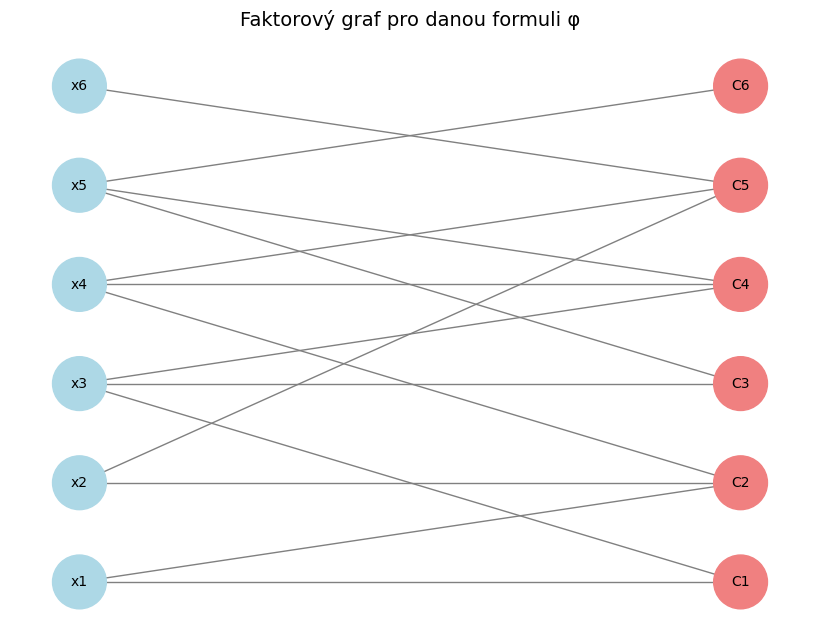

Spojení proměnných s klauzulemi:
  x1 ↔ C1, C2
  x2 ↔ C2, C5
  x3 ↔ C1, C3, C4
  x4 ↔ C2, C4, C5
  x5 ↔ C3, C4, C6
  x6 ↔ C5


In [26]:
# === FAKTOROVÝ GRAF PRO CNF FORMULI ===
# φ = (x1 ∨ ¬x3) ∧ (¬x1 ∨ x2 ∨ x4) ∧ (¬x3 ∨ x5) ∧ (¬x3 ∨ ¬x4 ∨ x5) ∧ (¬x2 ∨ x4 ∨ x6) ∧ (x5)

import networkx as nx
import matplotlib.pyplot as plt

# --- definice formule ---
clauses = [
    [1, -3],           # (x1 ∨ ¬x3)
    [-1, 2, 4],        # (¬x1 ∨ x2 ∨ x4)
    [-3, 5],           # (¬x3 ∨ x5)
    [-3, -4, 5],       # (¬x3 ∨ ¬x4 ∨ x5)
    [-2, 4, 6],        # (¬x2 ∨ x4 ∨ x6)
    [5],               # (x5)
]

# --- vytvoření prázdného grafu ---
G = nx.Graph()

# --- přidáme uzly proměnných a faktorů ---
num_clauses = len(clauses)
num_vars = 6

for i in range(1, num_vars + 1):
    G.add_node(f"x{i}", bipartite=0, color='lightblue')

for j in range(num_clauses):
    G.add_node(f"C{j+1}", bipartite=1, color='lightcoral')

# --- přidáme hrany mezi proměnnými a klauzulemi, kde se proměnné vyskytují ---
for j, clause in enumerate(clauses):
    for lit in clause:
        var = abs(lit)
        G.add_edge(f"x{var}", f"C{j+1}")

# --- pozice pro bipartitní vykreslení ---
var_nodes = [f"x{i}" for i in range(1, num_vars + 1)]
clause_nodes = [f"C{j+1}" for j in range(num_clauses)]

pos = {}
pos.update((n, (0, i)) for i, n in enumerate(var_nodes))
pos.update((n, (1, i)) for i, n in enumerate(clause_nodes))

# --- barvy ---
colors = [G.nodes[n]['color'] for n in G.nodes()]

# --- vykreslení ---
plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1500, font_size=10, edge_color="gray")
plt.title("Faktorový graf pro danou formuli φ", fontsize=14)
plt.show()

# --- výpis propojení ---
print("Spojení proměnných s klauzulemi:")
for v in var_nodes:
    adj = [n for n in G.neighbors(v)]
    print(f"  {v} ↔ {', '.join(adj)}")


Úkol 9

In [27]:
# ------------------------------------------------------------
# Simulace propagace výstrah ve faktoruovém (faktorovém) grafu
# ------------------------------------------------------------
# Klauzule: c1, c2, ..., c9
# Proměnné: x1, x2, ..., x8
#
# Plná hrana -> pozitivní výskyt proměnné v klauzuli
# Čárkovaná hrana -> negativní výskyt proměnné v klauzuli
#
# Ohodnocení hran určuje počáteční nastavení výstrah (0 nebo 1)
# Cílem je propagovat výstrahy přes celý graf, dokud nedojde k ustálení.
# ------------------------------------------------------------

# Definujeme hrany mezi klauzulemi a proměnnými
# Každá hrana: (klauzule, proměnná, typ, hodnota)
# typ = 1 pro pozitivní výskyt, -1 pro negativní výskyt
# hodnota = počáteční nastavení výstrahy (0 nebo 1)

edges = [
    ("c1", "x1", 1, 1),
    ("c2", "x2", 1, 1),
    ("c3", "x1", -1, 0),
    ("c3", "x3", 1, 1),
    ("c5", "x3", -1, 0),
    ("c5", "x5", 1, 0),
    ("c6", "x5", 1, 0),
    ("c6", "x4", 1, 1),
    ("c7", "x4", -1, 0),
    ("c7", "x7", 1, 0),
    ("c8", "x5", -1, 0),
    ("c8", "x8", 1, 0),
    ("c9", "x6", 1, 0)
]

# Inicializujeme výstrahy pro všechny hrany
warnings = {(c, x): value for (c, x, _, value) in edges}

# Pomocné struktury pro graf
clauses = {}
variables = {}

for c, x, t, v in edges:
    if c not in clauses:
        clauses[c] = []
    if x not in variables:
        variables[x] = []
    clauses[c].append((x, t))
    variables[x].append((c, t))

# Funkce pro aktualizaci výstrah
def propagate_warnings(warnings):
    changed = True
    while changed:
        changed = False
        new_warnings = warnings.copy()

        # Aktualizujeme výstrahy z klauzulí na proměnné
        for c, edges_c in clauses.items():
            for x, t in edges_c:
                # Výstraha se aktivuje, pokud všechny ostatní proměnné v klauzuli
                # mají hodnotu 1 (tedy klauzule je "téměř neuspokojitelná")
                other_vars = [v for v in edges_c if v[0] != x]
                if all(warnings[(c, v[0])] == 1 for v in other_vars if (c, v[0]) in warnings):
                    if new_warnings[(c, x)] != 1:
                        new_warnings[(c, x)] = 1
                        changed = True

        warnings = new_warnings

    return warnings


# Spustíme propagaci výstrah
final_warnings = propagate_warnings(warnings)

# Vypíšeme výsledky
print("=== Konečný stav výstrah ===")
for (c, x), value in final_warnings.items():
    print(f"{c} -> {x}: {value}")


=== Konečný stav výstrah ===
c1 -> x1: 1
c2 -> x2: 1
c3 -> x1: 1
c3 -> x3: 1
c5 -> x3: 0
c5 -> x5: 0
c6 -> x5: 1
c6 -> x4: 1
c7 -> x4: 0
c7 -> x7: 0
c8 -> x5: 0
c8 -> x8: 0
c9 -> x6: 1


Úkol 10

In [28]:
# ------------------------------------------------------------
# Různá kódování omezení AMO (At-Most-One)
# ------------------------------------------------------------
# Cílem je vytvořit logické klauzule (CNF), které zajistí,
# že z daných proměnných může být pravdivá nejvýše jedna.
#
# Implementujeme tři metody:
# 1) Pairwise (po dvojicích)
# 2) Produktové kódování
# 3) Sekvenční čítač
#
# Každá metoda vrací množinu klauzulí ve formátu seznamu seznamů.
# Např. [[-x1, -x2], [-x1, -x3], ...]
# ------------------------------------------------------------

from itertools import combinations

# Pomocná funkce: vygeneruje názvy proměnných
def gen_vars(n):
    return [f"x{i+1}" for i in range(n)]

# 1️⃣ Pairwise kódování: pro každou dvojici (xi, xj) přidáme klauzuli ¬xi ∨ ¬xj
def amo_pairwise(vars):
    clauses = []
    for (x1, x2) in combinations(vars, 2):
        clauses.append([f"-{x1}", f"-{x2}"])
    return clauses

# 2️⃣ Produktové kódování: proměnné se rozdělí do matice p × q, kde p*q >= n
# každý řádek a sloupec obsahuje max 1 pravdivou hodnotu
def amo_product(vars):
    import math
    n = len(vars)
    p = math.ceil(math.sqrt(n))
    q = math.ceil(n / p)
    matrix = [[None for _ in range(q)] for _ in range(p)]

    # přiřazení proměnných do matice
    k = 0
    for i in range(p):
        for j in range(q):
            if k < n:
                matrix[i][j] = vars[k]
                k += 1

    clauses = []
    # Řádková omezení
    for row in matrix:
        row_vars = [x for x in row if x]
        for (x1, x2) in combinations(row_vars, 2):
            clauses.append([f"-{x1}", f"-{x2}"])
    # Sloupcová omezení
    for j in range(q):
        col_vars = [matrix[i][j] for i in range(p) if matrix[i][j]]
        for (x1, x2) in combinations(col_vars, 2):
            clauses.append([f"-{x1}", f"-{x2}"])
    return clauses

# 3️⃣ Sekvenční čítač – přidává pomocné proměnné s_ij
# Podmínka: z n proměnných může být pravdivá nejvýše 1
def amo_sequential(vars):
    n = len(vars)
    clauses = []
    if n <= 1:
        return clauses

    # pomocné proměnné s_1, ..., s_(n-1)
    s = [f"s{i+1}" for i in range(n-1)]

    # První proměnná: ¬x1 ∨ s1
    clauses.append([f"-{vars[0]}", s[0]])

    # Poslední proměnná: ¬x_n ∨ ¬s_(n-1)
    clauses.append([f"-{vars[-1]}", f"-{s[-1]}"])

    # Střední kroky
    for i in range(1, n-1):
        clauses.append([f"-{vars[i]}", s[i]])          # ¬xi ∨ si
        clauses.append([f"-{s[i-1]}", s[i]])           # ¬s_(i-1) ∨ s_i
        clauses.append([f"-{vars[i]}", f"-{s[i-1]}"])  # ¬xi ∨ ¬s_(i-1)

    return clauses


# ------------------------------------------------------------
# DEMONSTRACE
# ------------------------------------------------------------
vars = gen_vars(5)  # např. 5 proměnných

pairwise = amo_pairwise(vars)
product = amo_product(vars)
sequential = amo_sequential(vars)

print("=== Pairwise kódování ===")
for c in pairwise:
    print(c)

print("\n=== Produktové kódování ===")
for c in product:
    print(c)

print("\n=== Sekvenční čítač ===")
for c in sequential:
    print(c)


=== Pairwise kódování ===
['-x1', '-x2']
['-x1', '-x3']
['-x1', '-x4']
['-x1', '-x5']
['-x2', '-x3']
['-x2', '-x4']
['-x2', '-x5']
['-x3', '-x4']
['-x3', '-x5']
['-x4', '-x5']

=== Produktové kódování ===
['-x1', '-x2']
['-x3', '-x4']
['-x1', '-x3']
['-x1', '-x5']
['-x3', '-x5']
['-x2', '-x4']

=== Sekvenční čítač ===
['-x1', 's1']
['-x5', '-s4']
['-x2', 's2']
['-s1', 's2']
['-x2', '-s1']
['-x3', 's3']
['-s2', 's3']
['-x3', '-s2']
['-x4', 's4']
['-s3', 's4']
['-x4', '-s3']


Úkol 11

In [29]:
# Cílem je umístit N královen na šachovnici N×N tak,
# aby se žádné dvě neohrožovaly (tj. nebyly ve stejné řadě,
# sloupci ani diagonále).
# Použijeme rekurzivní backtracking algoritmus.
# ------------------------------------------------------------

def solve_n_queens(n):
    """Vrátí seznam všech možných řešení pro N královen."""
    solutions = []
    cols = set()
    diag1 = set()  # diagonála r - c
    diag2 = set()  # diagonála r + c
    board = [-1] * n

    def backtrack(row):
        if row == n:
            solutions.append(board.copy())
            return
        for c in range(n):
            if c in cols or (row - c) in diag1 or (row + c) in diag2:
                continue
            cols.add(c)
            diag1.add(row - c)
            diag2.add(row + c)
            board[row] = c
            backtrack(row + 1)
            cols.remove(c)
            diag1.remove(row - c)
            diag2.remove(row + c)
            board[row] = -1

    backtrack(0)
    return solutions

def print_board(solution):
    """Vytiskne jedno řešení ve formě šachovnice."""
    n = len(solution)
    for r in range(n):
        row = ['.'] * n
        row[solution[r]] = 'Q'
        print(' '.join(row))
    print()

# --- DEMO ---
n = 8
reseni = solve_n_queens(n)
print(f"Nalezeno {len(reseni)} řešení pro {n}-královny.\n")
print_board(reseni[0])  # zobrazíme první řešení


Nalezeno 92 řešení pro 8-královny.

Q . . . . . . .
. . . . Q . . .
. . . . . . . Q
. . . . . Q . .
. . Q . . . . .
. . . . . . Q .
. Q . . . . . .
. . . Q . . . .



Úkol 12

In [30]:
# Vytvoříme jednoduchou neuronovou síť s jednou skrytou vrstvou.
# Trénujeme ji na booleovské funkci (např. XOR, AND, OR).
# ------------------------------------------------------------

import math, random

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def train_boolean_nn(X, Y, hidden=2, lr=0.5, epochs=5000):
    """Trénuje malou neuronovou síť na booleovské datech."""
    n_in = len(X[0])
    n_out = 1

    # inicializace vah
    W1 = [[random.uniform(-1, 1) for _ in range(n_in + 1)] for _ in range(hidden)]
    W2 = [random.uniform(-1, 1) for _ in range(hidden + 1)]

    for epoch in range(epochs):
        for i, x in enumerate(X):
            x_b = x + [1.0]
            # dopředný průchod
            h = [sigmoid(sum(W1[j][k]*x_b[k] for k in range(n_in+1))) for j in range(hidden)]
            h_b = h + [1.0]
            y_hat = sigmoid(sum(W2[k]*h_b[k] for k in range(hidden+1)))

            # chyba
            error = y_hat - Y[i]

            # zpětná propagace
            for k in range(hidden+1):
                W2[k] -= lr * error * y_hat * (1 - y_hat) * (h_b[k])

            for j in range(hidden):
                delta = error * y_hat * (1 - y_hat) * W2[j] * h[j] * (1 - h[j])
                for k in range(n_in+1):
                    W1[j][k] -= lr * delta * x_b[k]

    return W1, W2

def predict_nn(X, W1, W2):
    hidden = len(W1)
    preds = []
    for x in X:
        x_b = x + [1.0]
        h = [sigmoid(sum(W1[j][k]*x_b[k] for k in range(len(x_b)))) for j in range(hidden)]
        h_b = h + [1.0]
        y_hat = sigmoid(sum(W2[k]*h_b[k] for k in range(len(h_b))))
        preds.append(int(y_hat > 0.5))
    return preds

# --- DEMO: učení funkce XOR ---
X = [[0,0],[0,1],[1,0],[1,1]]
Y = [0,1,1,0]

W1, W2 = train_boolean_nn(X, Y)
preds = predict_nn(X, W1, W2)

print("Očekávané:", Y)
print("Predikce :", preds)


Očekávané: [0, 1, 1, 0]
Predikce : [0, 1, 1, 1]


Úkol 13

In [32]:
# Tato úloha ukazuje, jak lze převést problém nalezení
# rozhodovacího stromu (hloubka 1) na úlohu splnitelnosti (SAT).
#
# Použijeme velmi jednoduchý DPLL solver bez cyklů.
# ------------------------------------------------------------

from itertools import product

# -------------------------------
# Jednoduchý SAT solver (DPLL)
# -------------------------------
def simplify(clauses, assignment):
    """Zjednoduší CNF podle aktuálního přiřazení."""
    new_clauses = []
    for clause in clauses:
        satisfied = False
        new_clause = []
        for lit in clause:
            var = abs(lit)
            sign = (lit > 0)
            if var in assignment:
                # pokud je splněno, celá klauzule je splněna
                if assignment[var] == sign:
                    satisfied = True
                    break
                # jinak litera neplatí, vynecháme
            else:
                new_clause.append(lit)
        if not satisfied:
            new_clauses.append(new_clause)
    return new_clauses

def find_unit_clause(clauses, assignment):
    """Vrátí literál z jednotkové klauzule (pokud existuje)."""
    for clause in clauses:
        if len(clause) == 1:
            lit = clause[0]
            var = abs(lit)
            val = (lit > 0)
            # pokud je proměnná přiřazena opačně, konflikt
            if var in assignment and assignment[var] != val:
                return None, True
            if var not in assignment:
                return lit, False
    return None, False

def dpll(clauses, assignment=None):
    """Rekurzivní DPLL algoritmus."""
    if assignment is None:
        assignment = {}

    # zjednodušíme CNF
    clauses = simplify(clauses, assignment)

    # prázdné klauzule => splnitelné
    if not clauses:
        return assignment

    # konflikt (prázdná klauzule)
    if any(len(c) == 0 for c in clauses):
        return None

    # unit propagace
    lit, conflict = find_unit_clause(clauses, assignment)
    if conflict:
        return None
    if lit is not None:
        var = abs(lit)
        val = (lit > 0)
        new_assignment = assignment.copy()
        new_assignment[var] = val
        return dpll(clauses, new_assignment)

    # vybereme první neznámou proměnnou
    for clause in clauses:
        for lit in clause:
            var = abs(lit)
            if var not in assignment:
                for val in [True, False]:
                    new_assignment = assignment.copy()
                    new_assignment[var] = val
                    res = dpll(clauses, new_assignment)
                    if res is not None:
                        return res
                return None
    return assignment

# -------------------------------
# Redukce rozhodovacího stromu do SAT
# -------------------------------
def decision_tree_to_sat(X, Y):
    """
    Vytvoří CNF pro rozhodovací strom hloubky 1.
    f_i – testuje vlastnost i,
    lL – levý list má třídu 1,
    lR – pravý list má třídu 1.
    """
    n_features = len(X[0])
    f_vars = list(range(1, n_features + 1))
    l_left = n_features + 1
    l_right = n_features + 2

    clauses = []
    # (alespoň jedna feature zvolena)
    clauses.append(f_vars[:])
    # (nejvýše jedna feature)
    for i, j in product(f_vars, f_vars):
        if i < j:
            clauses.append([-i, -j])

    # trénovací omezení
    for xi, yi in zip(X, Y):
        for idx, f in enumerate(f_vars):
            if xi[idx] == 0:
                # levá větev
                if yi == 1:
                    clauses.append([-f, l_left])
                else:
                    clauses.append([-f, -l_left])
            else:
                # pravá větev
                if yi == 1:
                    clauses.append([-f, l_right])
                else:
                    clauses.append([-f, -l_right])

    return clauses, {"f": f_vars, "l_left": l_left, "l_right": l_right}

# -------------------------------
# DEMO
# -------------------------------
if __name__ == "__main__":
    # Booleovská funkce: y = x1 (tedy první vstup určuje výstup)
    X = [[0,0],[0,1],[1,0],[1,1]]
    Y = [0,0,1,1]

    clauses, mapping = decision_tree_to_sat(X, Y)
    model = dpll(clauses)

    print("=== Výsledek SAT ===")
    if model:
        print("Model nalezen.")
        for name, val in mapping.items():
            if isinstance(val, list):
                for v in val:
                    print(f"{name}{v} =", model.get(v, None))
            else:
                print(f"{name} =", model.get(val, None))
    else:
        print("Nesplnitelné (žádný strom neexistuje).")


=== Výsledek SAT ===
Model nalezen.
f1 = True
f2 = False
l_left = False
l_right = True
